# Neural networks based approximation of an analytical function

In this notebook, we will show how to train a neural network to approximate a knwon analytical function. The same procedure can be used to approximate a unknown function, for example using real world data.

By convenience, the neural network implementation of this package handle the conversion between NumPy and PyTorch so we won't directly manipulate any PyTorch `Tensor` in this notebook.

The analytical function and the network will be saved in the `out-training` directory, so this notebook is also an introduction to `.save` and `.load` methods of the abstract class `NeuralNetwork`.

In [31]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(''), ".."))

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from nnbma.networks import FullyConnected
from nnbma.dataset import RegressionDataset
from nnbma.learning import learning_procedure, LearningParameters

## Definition of the analytical function

In the following cell, we implement in NumPy the vectorial function $ f: \left(\begin{array}{c} t_1\\ t_2 \end{array}\right) \longmapsto \left(\begin{array}{c} t_1+t_2\\ t_1^2+t_2^2\\ t_1^3 + t_2^3 \end{array}\right) $.

In [32]:
n_inputs, n_outputs = 2, 3

def f(t: np.ndarray) -> np.ndarray:
    """
    Implements the (t1, t2) -> (t1+t1, t1^2+t2^2, t1^3+t2^3) function in numpy.
    This function takes batched inputs, so the inputs must have a shape [N, 2] where N is the batch size i.e. the number of inputs that are computed simultaneously.
    The output is of shape [N, 3].
    """
    if t.ndim != 2:
        raise ValueError(f"t must have 2 dimensions, not {t.ndim}")
    if t.shape[1] != n_inputs:
        raise ValueError(f"t.shape[1] must be {n_inputs}, not {t.shape[1]}")
    return np.column_stack((t.sum(1), (t**2).sum(1), (t**3).sum(1)))

In [33]:
ranges = [(-2, 2), (-1, 1)]

For instance, we can plot some profile of this function:

In [34]:
n_points = 100
default_values = [0, 0]

x = np.column_stack(
    [np.linspace(*ranges[k], n_points) for k in range(n_inputs)]
)
print("x.shape:", x.shape)

y = f(x)
print("y.shape:", y.shape)


x.shape: (100, 2)
y.shape: (100, 3)


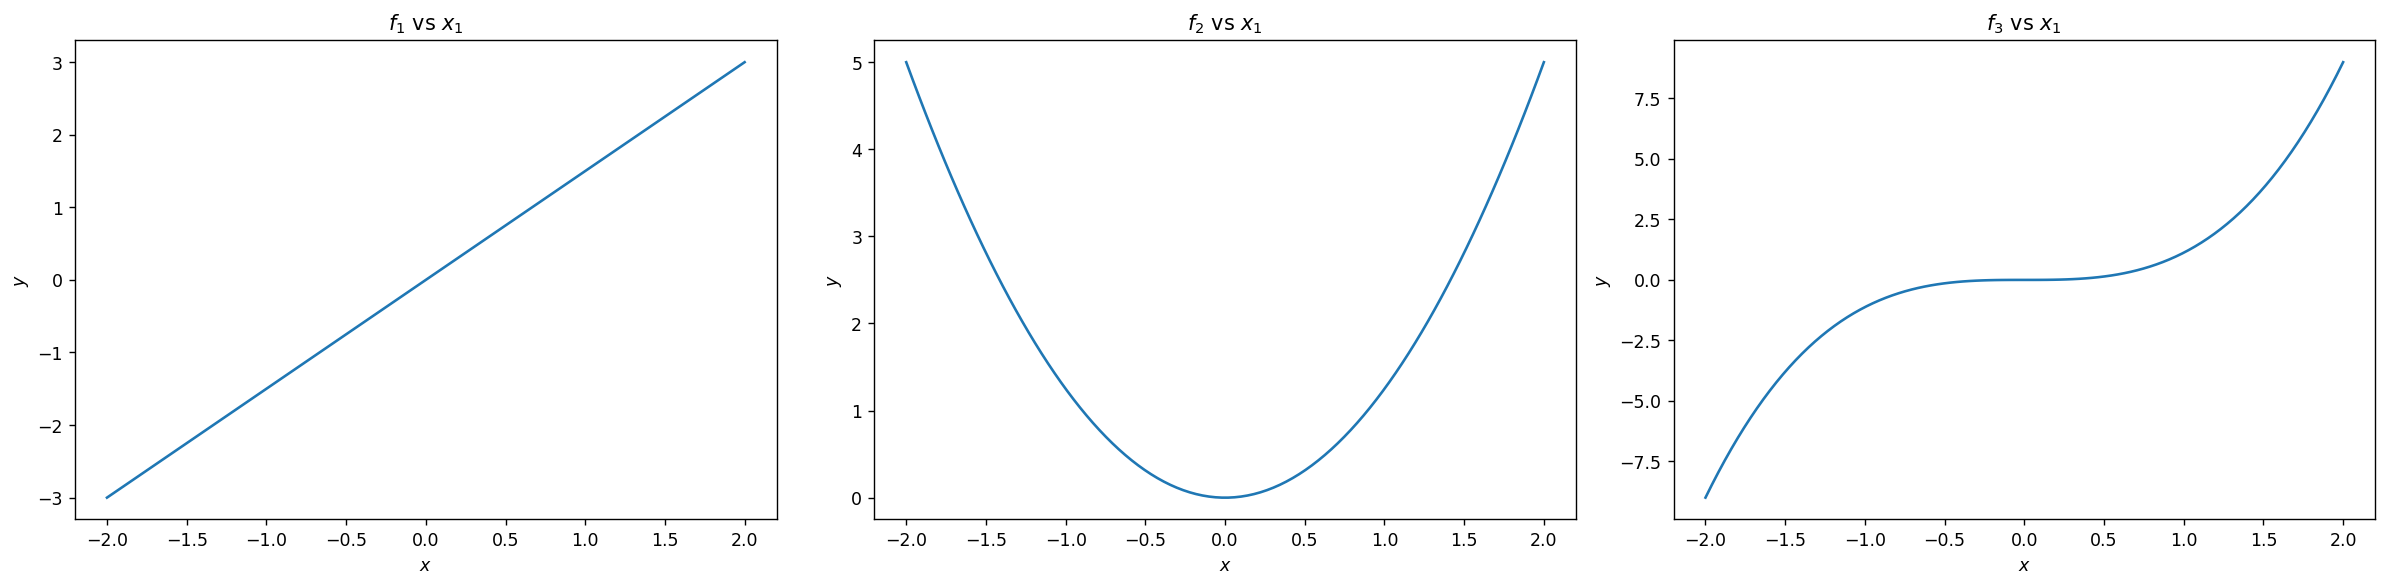

In [35]:
free_input = 1

plt.figure(dpi=125, figsize=(6.4*n_outputs, 4.8))

for k in range(n_outputs):
    plt.subplot(1, n_outputs, k+1)
    plt.plot(x[:, free_input-1], y[:, k])

    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title(f"$f_{k+1}$ vs $x_{free_input}$")

plt.tight_layout()

plt.show()


We can also draw a bivariate plot:

In [36]:
n_points = 100
default_values = [0, 0]

X = np.meshgrid(*[np.linspace(*ranges[k], n_points) for k in range(n_inputs)])
x_mesh = np.column_stack([X[k].flatten() for k in range(n_inputs)])
print("x_mesh.shape:", x_mesh.shape)

y_mesh = f(x_mesh)
print("y_mesh.shape:", y_mesh.shape)

Y = y_mesh.reshape(n_points, n_points, n_outputs)

x_mesh.shape: (10000, 2)
y_mesh.shape: (10000, 3)


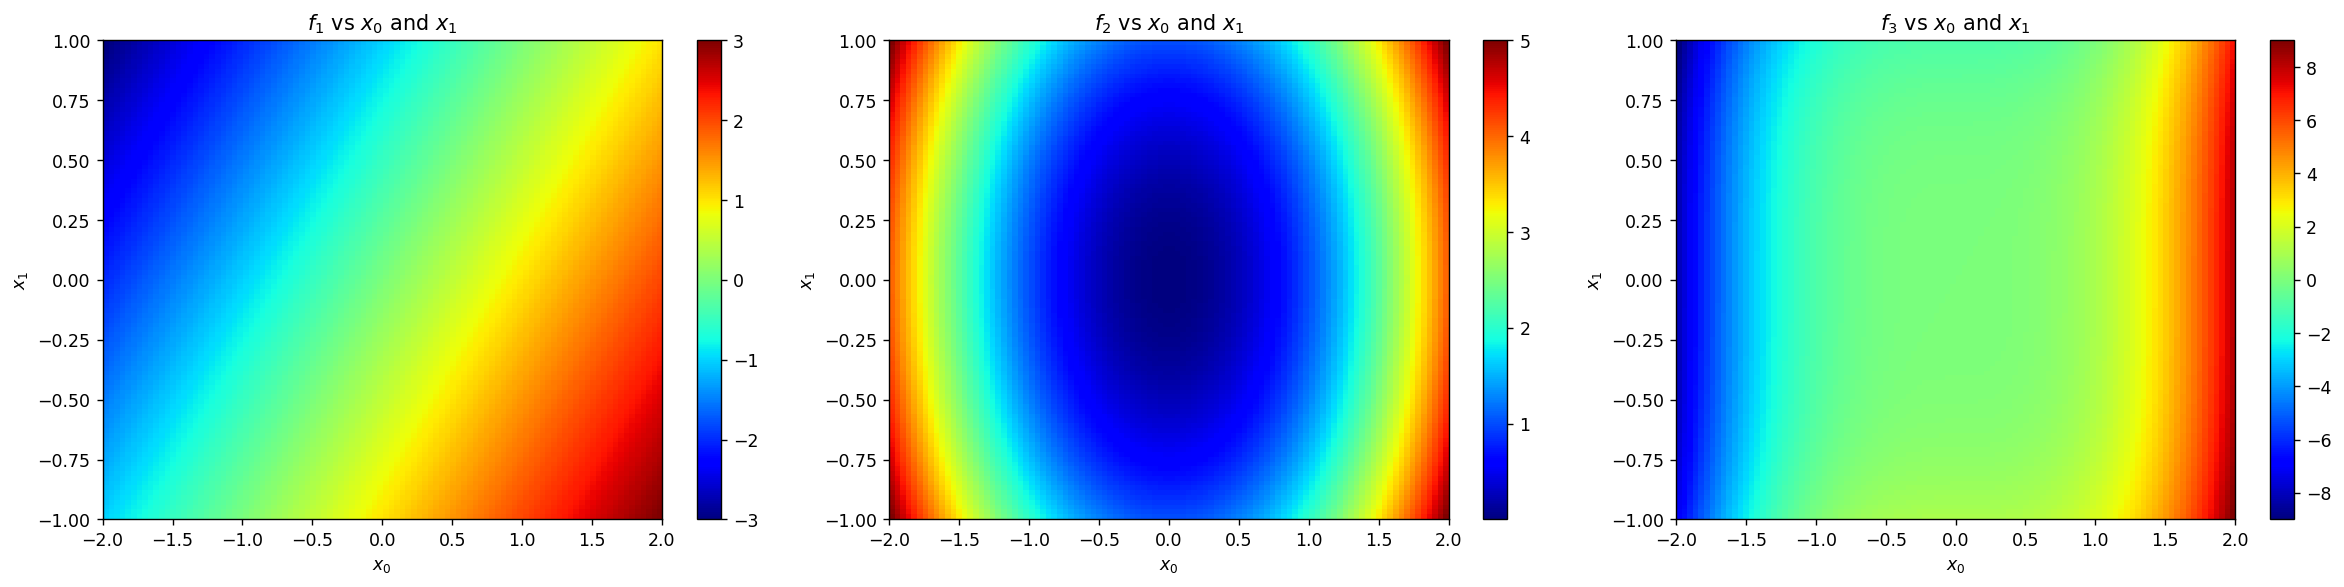

In [37]:
free_inputs = [1, 2]

plt.figure(dpi=125, figsize=(6.4*n_outputs, 4.8))

for k in range(n_outputs):
    plt.subplot(1, n_outputs, k+1)
    plt.imshow(
        Y[:, :, k], cmap="jet", aspect="auto", extent=[
            ranges[free_inputs[0]-1][0], ranges[free_inputs[0]-1][1],
            ranges[free_inputs[1]-1][0], ranges[free_inputs[1]-1][1],
        ],
    )
    plt.colorbar()

    plt.xlabel(f"$x_{free_inputs[0]-1}$")
    plt.ylabel(f"$x_{free_inputs[1]-1}$")
    plt.title(f"$f_{k+1}$ vs $x_{free_inputs[0]-1}$ and $x_{free_inputs[1]-1}$")

plt.tight_layout()

plt.show()

## Creation of a neural network

We will create a fully connected neural network. To do so, we have to define, some hyperparameters:
* the number of hidden layers
* their respective number of neurons

In [38]:
layers_sizes = [n_inputs, 50, 50, n_outputs]
activation = nn.ELU()

net_0 = FullyConnected(
    layers_sizes,
    activation,
)

net = net_0.copy()

The weights are initialized randomly so, before any training, we obtain plots like that:

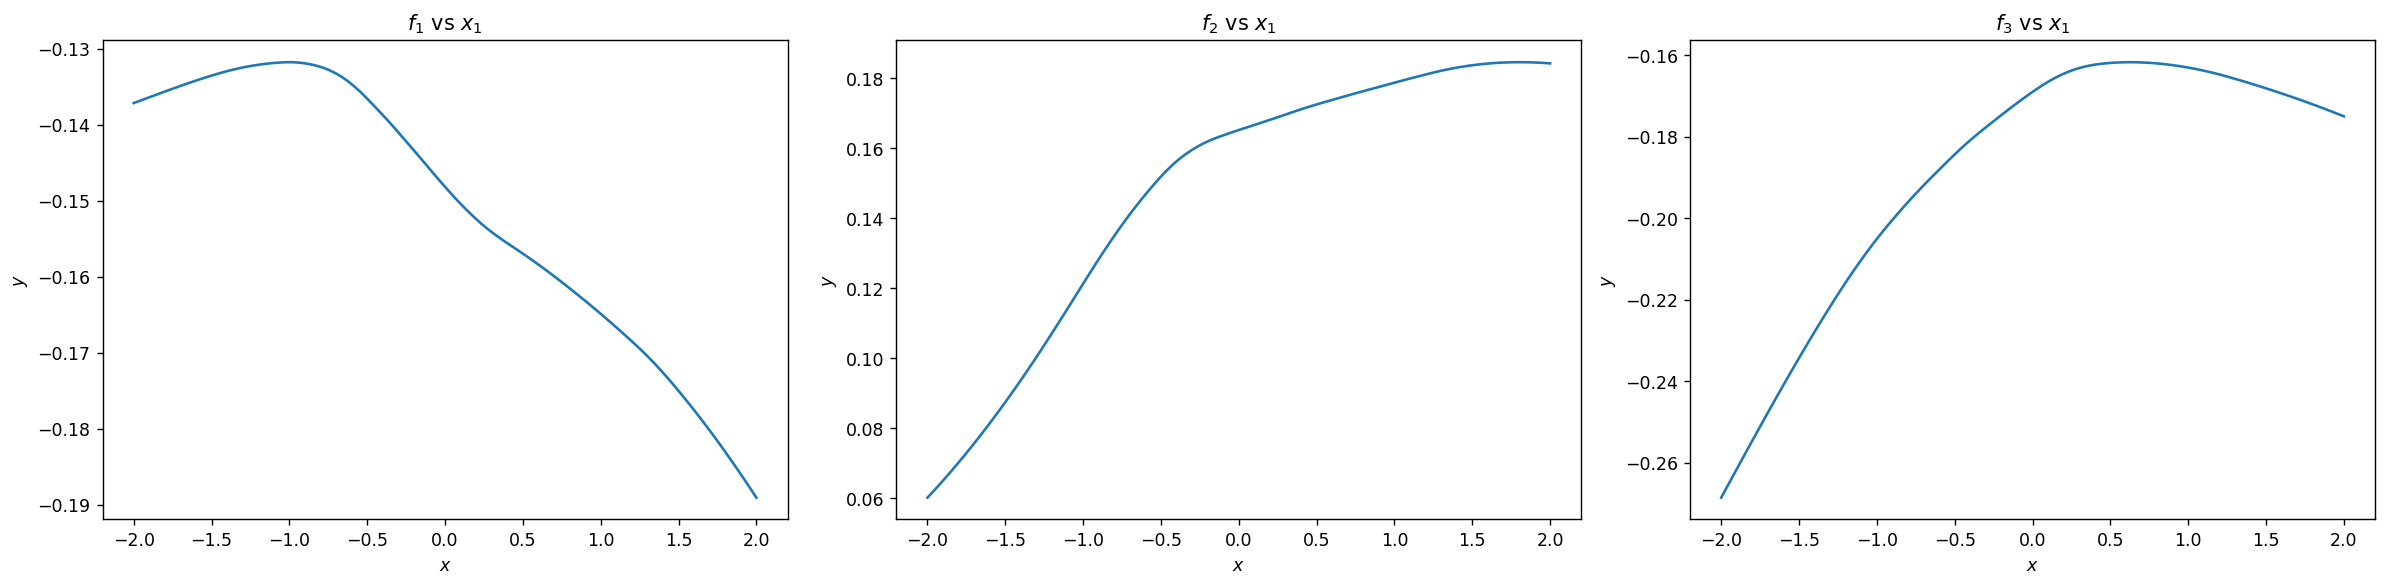

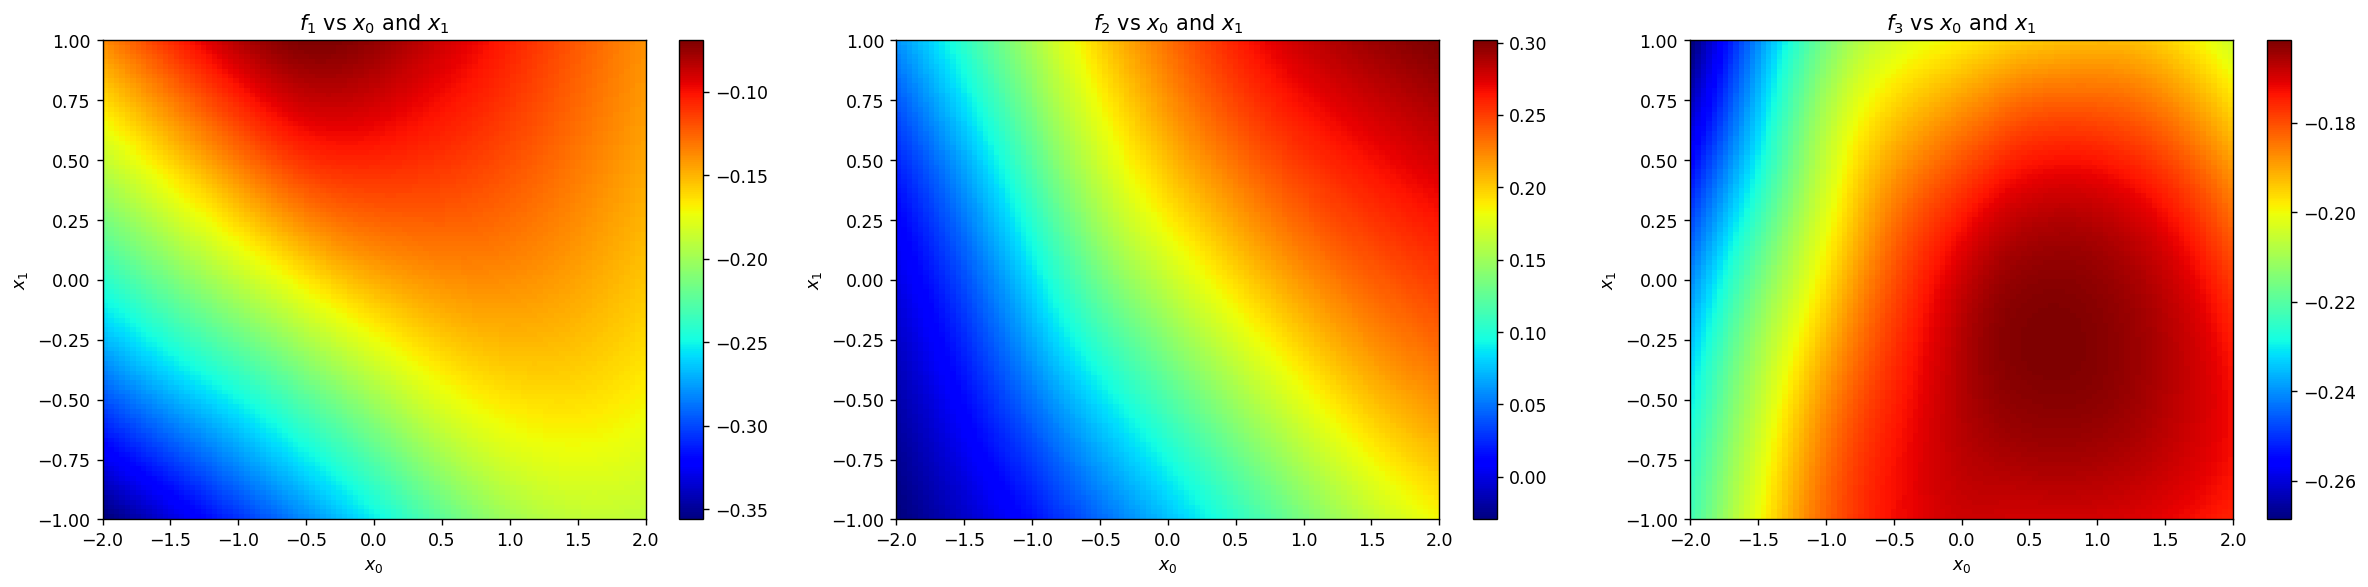

In [39]:
y_net_0 = net_0(x)

plt.figure(dpi=125, figsize=(6.4*n_outputs, 4.8))

for k in range(n_outputs):
    plt.subplot(1, n_outputs, k+1)
    plt.plot(x[:, free_input-1], y_net_0[:, k])

    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title(f"$f_{k+1}$ vs $x_{free_input}$")

plt.tight_layout()

plt.show()

#

y_mesh_net_0 = net_0(x_mesh)
Y_net_0 = y_mesh_net_0.reshape(n_points, n_points, n_outputs)

plt.figure(dpi=125, figsize=(6.4*n_outputs, 4.8))

for k in range(n_outputs):
    plt.subplot(1, n_outputs, k+1)
    plt.imshow(
        Y_net_0[:, :, k], cmap="jet", aspect="auto", extent=[
            ranges[free_inputs[0]-1][0], ranges[free_inputs[0]-1][1],
            ranges[free_inputs[1]-1][0], ranges[free_inputs[1]-1][1],
        ],
    )
    plt.colorbar()

    plt.xlabel(f"$x_{free_inputs[0]-1}$")
    plt.ylabel(f"$x_{free_inputs[1]-1}$")
    plt.title(f"$f_{k+1}$ vs $x_{free_inputs[0]-1}$ and $x_{free_inputs[1]-1}$")

plt.tight_layout()

plt.show()

## Training of the network

We will train this network in order to approximate the previous function. To do so, we generate a dataset of randomly distributed points (not a grid like the one used to draw the figures).

The following cell controls the size of the whole dataset, and which fraction of it will be used to test the model instead of improve its learning.

In [40]:
n_data = 1_000
test_frac = 0.20

In [41]:
input_data = np.column_stack(
    [np.random.uniform(*ranges[k], n_data) for k in range(n_inputs)]
)
output_data = f(input_data)

dataset = RegressionDataset(input_data, output_data)

We also need some parameters to control the learning procedure:
* the number of epochs
* the batch size
* the loss function
* the learning rate
* the optimizer
* the scheduler

In [42]:
# Epochs
epochs = 100

# Batch size
batch_size = 10

# Loss function
loss = nn.MSELoss()

# Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(net.parameters(), learning_rate)

# Scheduler
gamma = (1e-2)**(1/epochs)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

The next cell will launch the training procedure. It will modify the weights of the network in-place.

In [43]:
learning_params = LearningParameters(loss, epochs, batch_size, optimizer, scheduler)

results = learning_procedure(
    net,
    dataset,
    learning_params,
    val_frac=test_frac,
)

print("Results keys:", list(results.keys()))

Training initiated
FullyConnected:
	layers_sizes: [2, 50, 50, 3]
	activation: ELU(alpha=1.0)
	batch_norm: False
	inputs_names: None
	outputs_names: None
	inputs_transformer: None
	outputs_transformer: None
	device: cpu
	last_restrictable: True
: 2,853 learnable parameters (11.41 kB)



Epoch: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s, train loss=0.00883, val loss=0.0105, train error=16.92%, val error=18.89%]


Results keys: ['train_loss', 'val_loss', 'train_relerr', 'val_relerr', 'train_set', 'val_set', 'lr', 'batch_size', 'duration']


We can plot the evolution of both train and test loss:

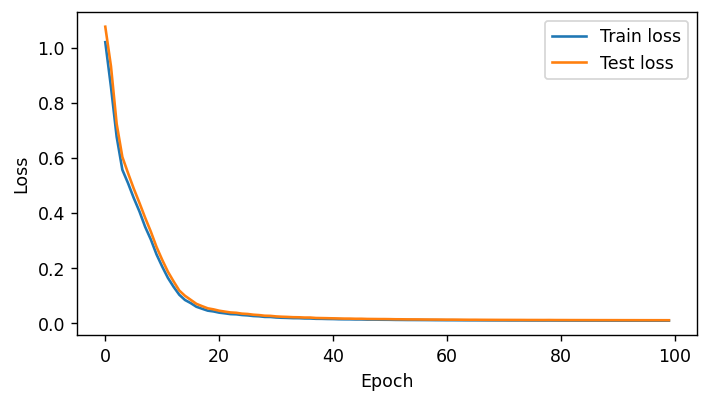

In [44]:
plt.figure(dpi=125, figsize=(6.4, 0.7*4.8))

plt.plot(results["train_loss"], label="Train loss")
plt.plot(results["val_loss"], label="Test loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

We now diplay the new plots with the trained network

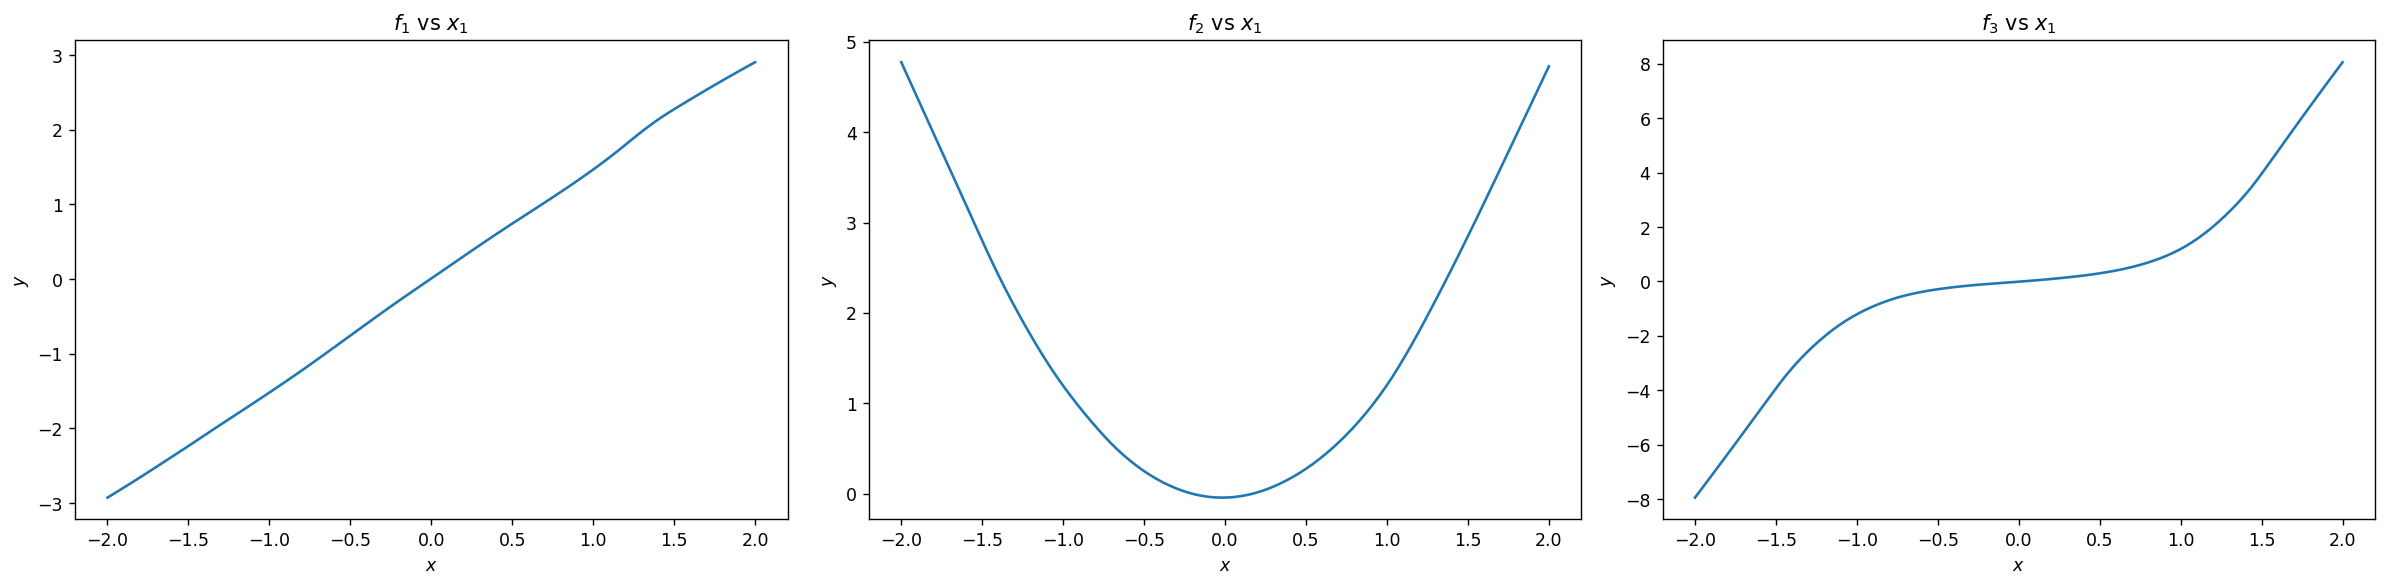

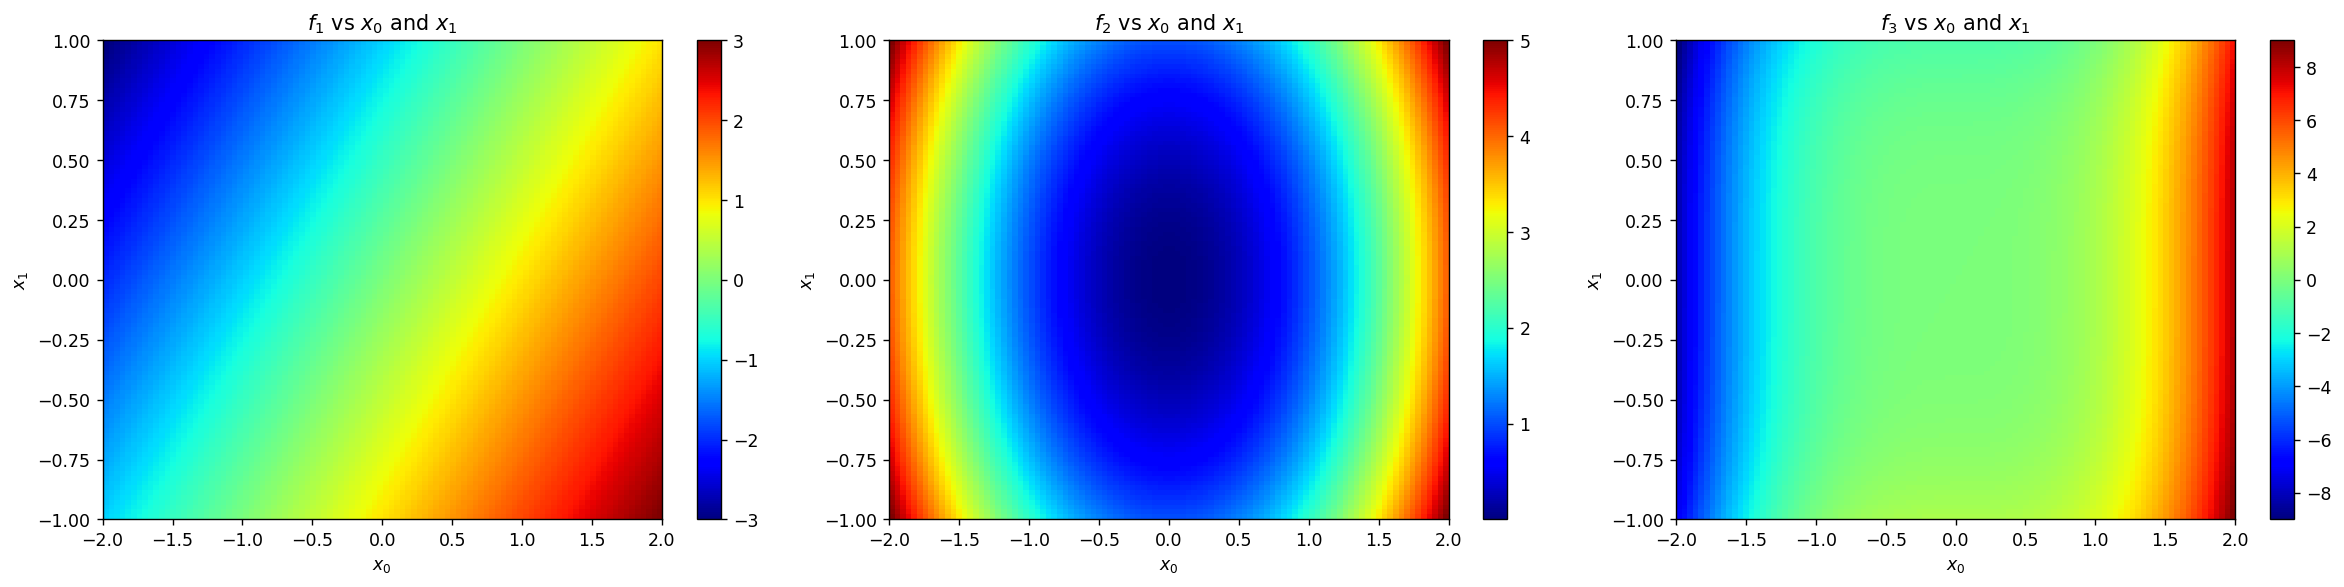

In [45]:
y_net = net(x)

plt.figure(dpi=125, figsize=(6.4*n_outputs, 4.8))

for k in range(n_outputs):
    plt.subplot(1, n_outputs, k+1)
    plt.plot(x[:, free_input-1], y_net[:, k])

    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title(f"$f_{k+1}$ vs $x_{free_input}$")

plt.tight_layout()

plt.show()

#

y_mesh_net = net(x_mesh)
Y_net = y_mesh_net.reshape(n_points, n_points, n_outputs)

plt.figure(dpi=125, figsize=(6.4*n_outputs, 4.8))

for k in range(n_outputs):
    plt.subplot(1, n_outputs, k+1)
    plt.imshow(
        Y[:, :, k], cmap="jet", aspect="auto", extent=[
            ranges[free_inputs[0]-1][0], ranges[free_inputs[0]-1][1],
            ranges[free_inputs[1]-1][0], ranges[free_inputs[1]-1][1],
        ],
    )
    plt.colorbar()

    plt.xlabel(f"$x_{free_inputs[0]-1}$")
    plt.ylabel(f"$x_{free_inputs[1]-1}$")
    plt.title(f"$f_{k+1}$ vs $x_{free_inputs[0]-1}$ and $x_{free_inputs[1]-1}$")

plt.tight_layout()

plt.show()

And the differences between the original function

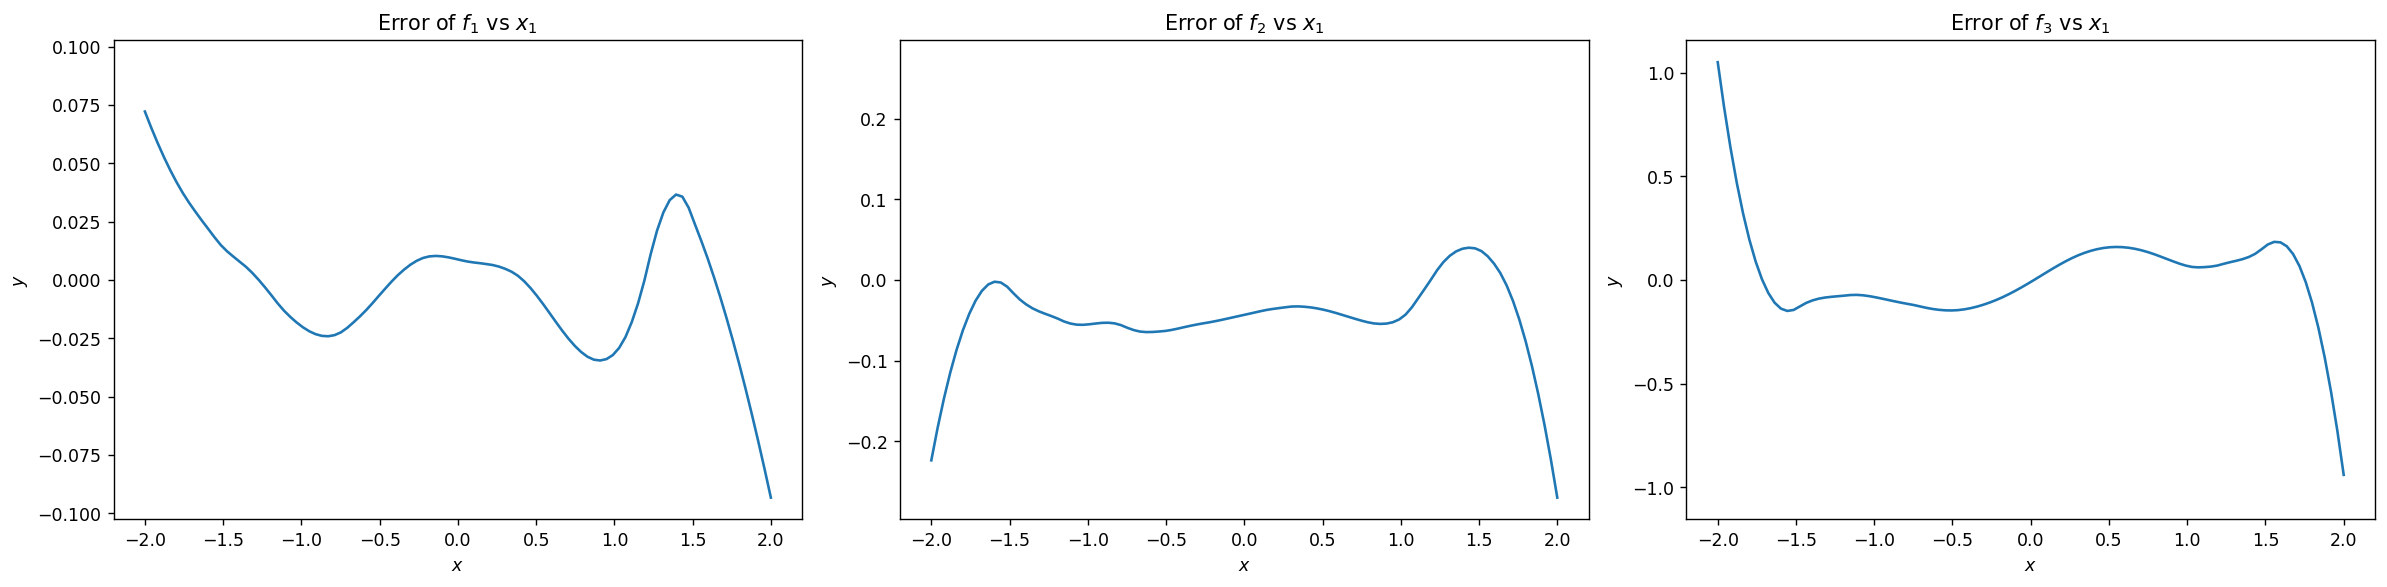

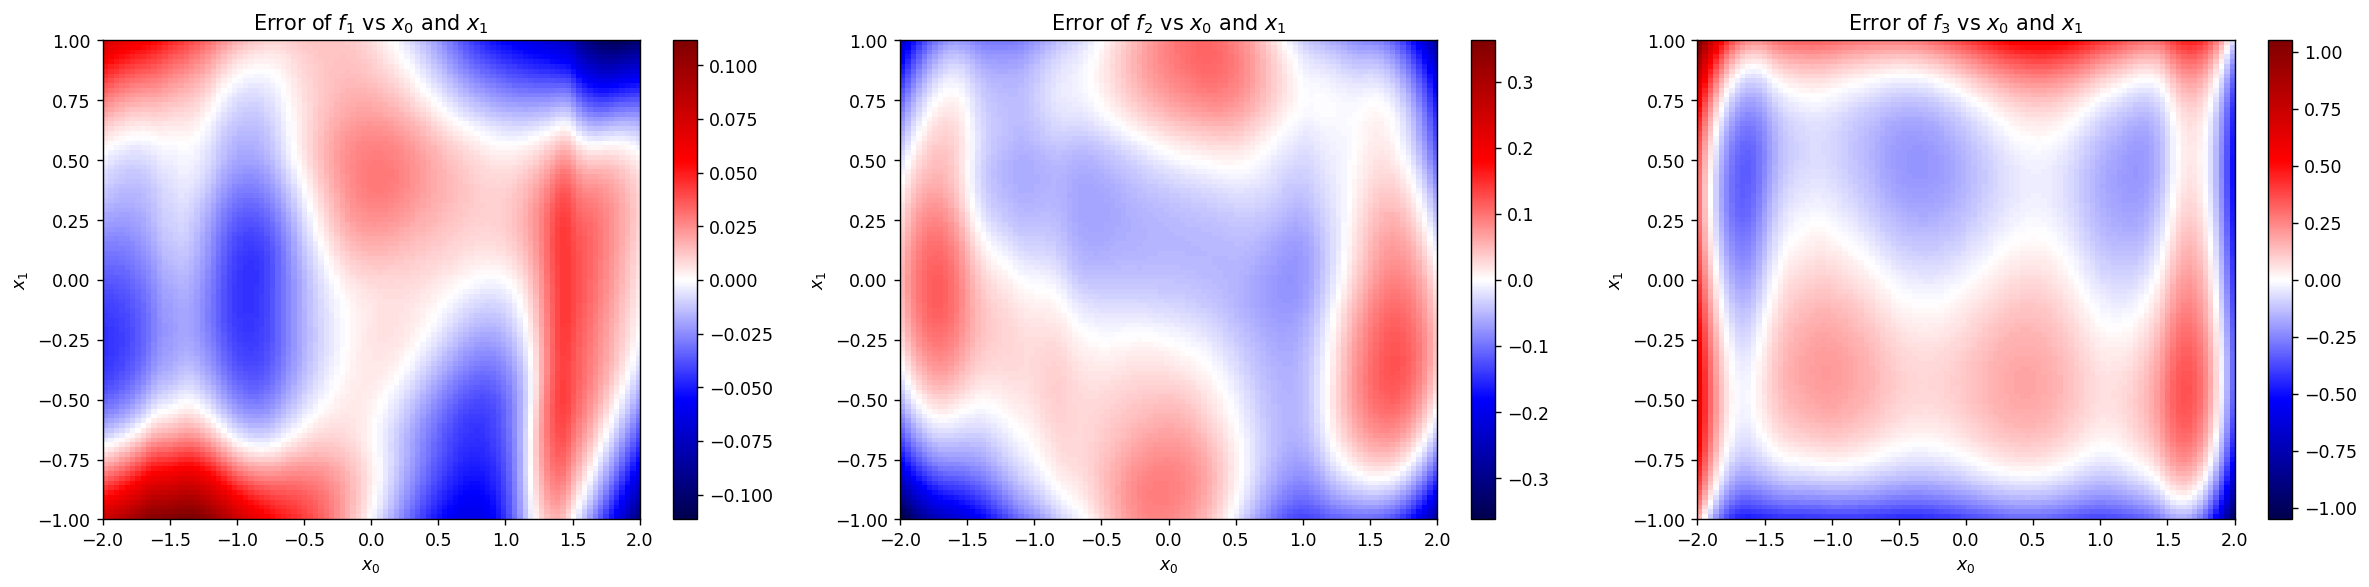

In [46]:
error_net = y_net - y

plt.figure(dpi=125, figsize=(6.4*n_outputs, 4.8))

for k in range(n_outputs):
    vmax = np.abs(error_net[:, k]).max()

    plt.subplot(1, n_outputs, k+1)
    plt.plot(x[:, free_input-1], error_net[:, k])
    plt.ylim([-1.1*vmax, 1.1*vmax])

    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title(f"Error of $f_{k+1}$ vs $x_{free_input}$")

plt.tight_layout()

plt.show()

#

error_mesh_net = y_mesh_net - y_mesh
Error_mesh_net = error_mesh_net.reshape(n_points, n_points, n_outputs)

plt.figure(dpi=125, figsize=(6.4*n_outputs, 4.8))

for k in range(n_outputs):
    vmax = np.abs(Error_mesh_net[:, :, k]).max()

    plt.subplot(1, n_outputs, k+1)
    plt.imshow(
        Error_mesh_net[:, :, k], cmap="seismic", aspect="auto", extent=[
            ranges[free_inputs[0]-1][0], ranges[free_inputs[0]-1][1],
            ranges[free_inputs[1]-1][0], ranges[free_inputs[1]-1][1],
        ], vmin=-vmax, vmax=vmax,
    )
    plt.colorbar()

    plt.xlabel(f"$x_{free_inputs[0]-1}$")
    plt.ylabel(f"$x_{free_inputs[1]-1}$")
    plt.title(f"Error of $f_{k+1}$ vs $x_{free_inputs[0]-1}$ and $x_{free_inputs[1]-1}$")

plt.tight_layout()

plt.show()

## Save of the network

In this last part, we will show how to save and load a neural network. Using the `save` function from PyTorch, we can also save the analytical function:

In [47]:
path = os.path.join(os.path.splitext(os.path.abspath(''))[0], "out-training")

net.save("network", path)
torch.save(f, os.path.join(path, "function.pth"))

We can now load these objects:

In [48]:
loaded_f = torch.load(os.path.join(path, "function.pth"))
print(loaded_f)

loaded_net = FullyConnected.load("network", path)
print(loaded_net)

<function f at 0x7fe8ec1267a0>
FullyConnected:
	layers_sizes: [2, 50, 50, 3]
	activation: ELU(alpha=1.0)
	batch_norm: False
	inputs_names: None
	outputs_names: None
	inputs_transformer: None
	outputs_transformer: None
	device: cpu
	last_restrictable: True



We can verify that the loaded network has the same weight than the one that have been trained:

In [49]:
print("Difference of outputs between net and loaded_net:", np.mean(loaded_net(x)-net(x)))

Difference of outputs between net and loaded_net: 0.0
